Having defined three different 'policies' that split each patient into actions, we now want to calculate the overall return of those policies by determining the cost of each patient/action pair, and averaging that over the total patient set.

In [1]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import copy
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime
from collections import Counter

#Dumping stuff
import pickle

#Plotting stuff
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from matplotlib.pyplot import figure
from matplotlib.ticker import FormatStrFormatter
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()



In [2]:
#First, the vectors of patients in each category for each policy.
#The order is
#need atb/get atb, need atb/get atm, need atb/get both, need atb/get neither
#need atm/get atb, need atm/get atm, need atm/get both, need atm/get neither
#need atb/get atb, need both/get atm, need both/get both, need both/get neither
#need n/get atb, need n/get atm, need n/get both, need n/get n (these last 4 are always 0)
#how many needed atb? 51 how many needed atm? 20 how many needed both? 109
IntakeCats = np.array([21,1,1,28,0,11,0,9,7,19,57,26,0,0,0,0])
MLCats = np.array([35,0,16,0,0,12,8,0,16,20,73,0,0,0,0,0])
KitchenSinkCats = np.array([0,0,51,0,0,0,20,0,0,0,109,0,0,0,0,0])

Npatient = sum(IntakeCats)

In [3]:
#Now, you need to define the cost for each category. This should be in terms of variables you can change.
#You have pre-determined here that giving someone 1/2 treatment is 1/2 as bad as a complete miss.
f1 = -2.    #How bad is it to completely miss someone's treatment?
f2 = 0.5    #How bad is it to waste an antimalarial or antibiotic? (same for now)
C = np.array([1.,f1,f2,f1,f1,1.,f2,f1,-1.,-1.,1.,f1,f2,f2,2.*f2,1.])

In [4]:
print np.sum(IntakeCats*C)/Npatient
print np.sum(MLCats*C)/Npatient
print np.sum(KitchenSinkCats*C)/Npatient

-0.35833333333333334
0.5333333333333333
0.8027777777777778


In [5]:
nplot = 20
f1range = np.linspace(-5.,0.,nplot)
f2range = np.linspace(-5.,1.,nplot)

CmatI = np.zeros([nplot,nplot])
CmatML = np.zeros([nplot,nplot])
CmatKS = np.zeros([nplot,nplot])
BestP = np.zeros([nplot,nplot])

i = 0
for f1 in f1range:
    j = 0
    for f2 in f2range:
        C = np.array([1.,f1,f2,f1,f1,1.,f2,f1,-1.,-1.,1.,f1,f2,f2,2.*f2,1.])
        CmatI[i,j] = np.sum(IntakeCats*C)/Npatient
        CmatML[i,j] = np.sum(MLCats*C)/Npatient
        CmatKS[i,j] = np.sum(KitchenSinkCats*C)/Npatient        
        
        if np.max([CmatKS[i,j],CmatML[i,j],CmatI[i,j]])==CmatI[i,j]:
            BestP[i,j] = 0.
        elif np.max([CmatKS[i,j],CmatML[i,j],CmatI[i,j]])==CmatML[i,j]:
            BestP[i,j] = 1.
        elif np.max([CmatKS[i,j],CmatML[i,j],CmatI[i,j]])==CmatKS[i,j]:
            BestP[i,j] = 2.
        else:
            print 'Tie!', CmatI[i,j], CmatML[i,j], CmatKS[i,j]
            BestP[i,j] = 3.
        
        j += 1
    i += 1


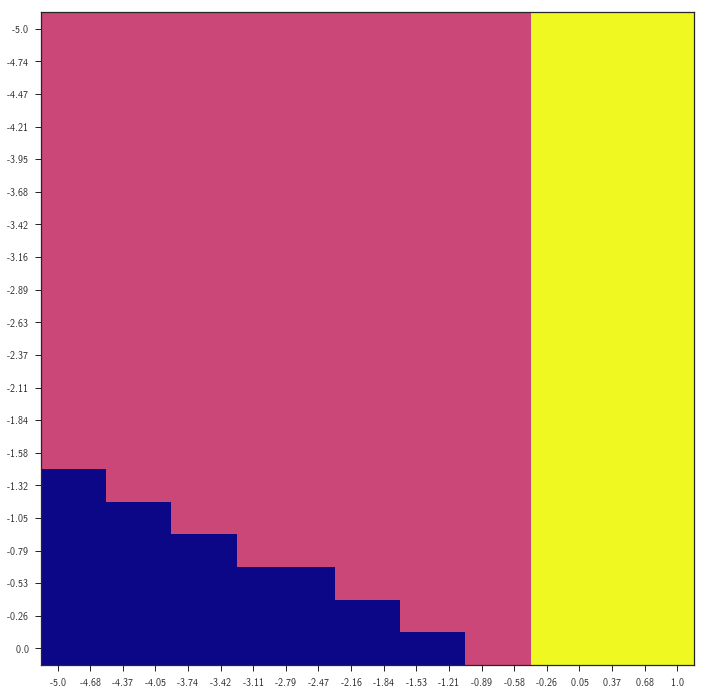

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.imshow(BestP, interpolation='none', cmap='plasma');
ax.set_xticks(np.arange(0,nplot,1));
ax.set_yticks(np.arange(0,nplot,1));
#ax.set_xticklabels(f2range,fontsize=12);
#ax.set_yticklabels(f1range,fontsize=12);
# get the current labels 
#labels = [item.get_text() for item in ax.get_xticklabels()]
# Beat them into submission and set them back again
ax.set_xticklabels([str(round(float(label), 2)) for label in f2range]);
ax.set_yticklabels([str(round(float(label), 2)) for label in f1range]);
#ax.set_xlabel('Population Size',fontsize=15)
#ax.set_ylabel('Pop. Variance (\%)',fontsize=15)
plt.savefig('BestPolicy.png')


### Return per patient: equations for the costs

Given that there are two possible drugs, lets just call them $A$ and $B$, (although those correspond in our case to antibiotics and antimalarials), each cell in the 'cost/action matrix' can be defined by four numbers.


$\begin{array}
 nn_A &= (0,1), \quad\quad \rm{need\,A?}\\   
 n_B &= (0,1), \quad\quad \rm{need\,B?}\\
 g_A &= (0,1), \quad\quad \rm{get\,A?}\\
 g_B &= (0,1), \quad\quad \rm{get\,B?}\\
\end{array}$

We can then define the cost of each of the cells, which are now uniquely defined by $(n_A,n_B,g_A,g_B)$, as:

$\rm{cost} = \left[\left\{n_Ag_A + n_Bg_B\right\} + f_1\times\left\{n_A(1-g_A)+n_B(1-g_B)\right\} + f_2\times\left\{(1-n_A)g_A+(1-n_B)g_B\right\}\right]\bigg/(n_A+n_B)$

The first term rewards the policy for giving drugs that were needed. The second term penalizes the policy for *not* giving drugs that *were* needed (missed treatment), and the third term penalizes the policy for *giving* drugs that were *not* needed (wasted treatment). The denominator scales the answer such that perfect treatment gives a return of 1. $f_1$ and $f_2$ scale the degree of the penalty accrued from missing or wasting treatment, respecitvely. As formulated, rewards and penalties for drug A and drug B are equal, but this could be adjusted.


In [7]:
#Loop through a grid of values in f1 and f2. 
nplot = 20
f1range = np.linspace(0.,3.,nplot)
f2range = np.linspace(0.,3.,nplot)

CmatI = np.zeros([nplot,nplot])
CmatML = np.zeros([nplot,nplot])
CmatKS = np.zeros([nplot,nplot])
BestP = np.zeros([nplot,nplot])

i = 0
for f1 in f1range:
    j = 0
    for f2 in f2range:
        C = np.array([1.,-(f1+f2),1.-f2,-f1,-(f1+f2),1.,1.-f2,-f1,(1.-f1)/2.,(1.-f1)/2.,1.,-f1,-f2,-f2,-2.*f2,1.])
        CmatI[i,j] = np.sum(IntakeCats*C)/Npatient
        CmatML[i,j] = np.sum(MLCats*C)/Npatient
        CmatKS[i,j] = np.sum(KitchenSinkCats*C)/Npatient        
        
        if np.max([CmatKS[i,j],CmatML[i,j],CmatI[i,j]])==CmatI[i,j]:
            BestP[i,j] = 0.
        elif np.max([CmatKS[i,j],CmatML[i,j],CmatI[i,j]])==CmatML[i,j]:
            BestP[i,j] = 1.
        elif np.max([CmatKS[i,j],CmatML[i,j],CmatI[i,j]])==CmatKS[i,j]:
            BestP[i,j] = 2.
        else:
            print 'Tie!', CmatI[i,j], CmatML[i,j], CmatKS[i,j]
            BestP[i,j] = 3.
        
        j += 1
    i += 1

In [8]:
print np.max(CmatKS)

1.0


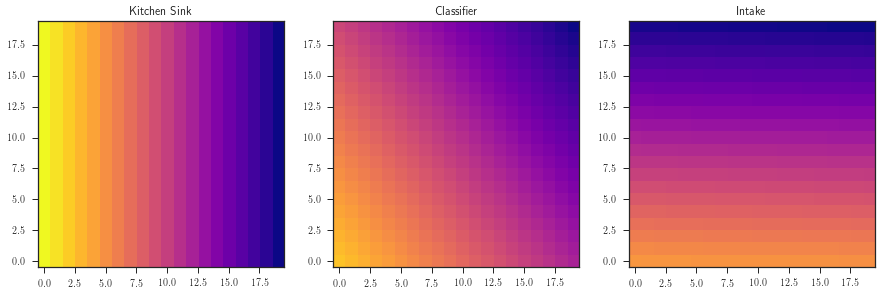

In [9]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,15))
ax2.imshow(CmatML,cmap='plasma',vmax=1.)
ax2.set_title('Classifier')
ax1.imshow(CmatKS,cmap='plasma',vmax=1.)
ax1.set_title('Kitchen Sink')
ax3.imshow(CmatI,cmap='plasma',vmax=1.)
ax3.set_title('Intake')

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()


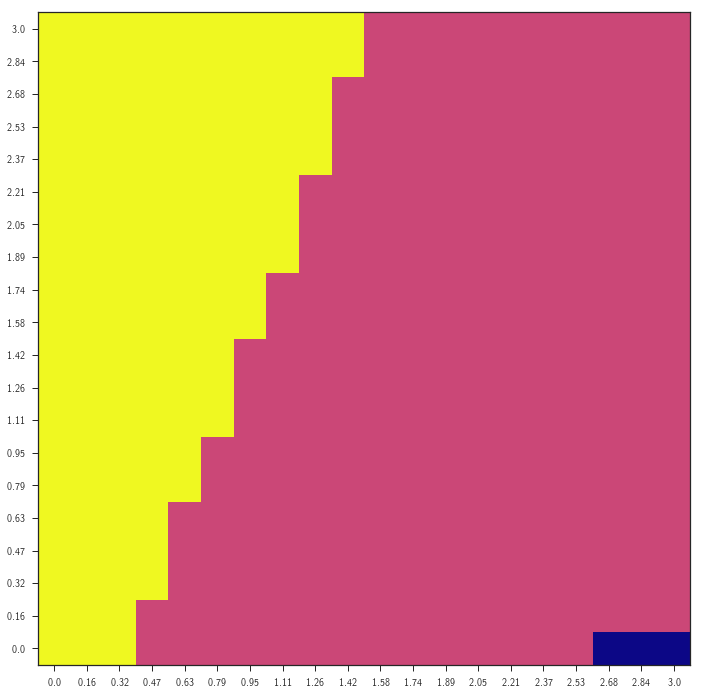

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.imshow(BestP, interpolation='none', cmap='plasma');
ax.set_xticks(np.arange(0,nplot,1));
ax.set_yticks(np.arange(0,nplot,1));
#ax.set_xticklabels(f2range,fontsize=12);
#ax.set_yticklabels(f1range,fontsize=12);
# get the current labels 
#labels = [item.get_text() for item in ax.get_xticklabels()]
# Beat them into submission and set them back again
ax.set_xticklabels([str(round(float(label), 2)) for label in f2range]);
ax.set_yticklabels([str(round(float(label), 2)) for label in f1range]);
plt.gca().invert_yaxis()
#ax.set_xlabel('Population Size',fontsize=15)
#ax.set_ylabel('Pop. Variance (\%)',fontsize=15)
plt.savefig('BestPolicy_truepopulation.png')

In [11]:
#Now, to illustrate what impact the underlying population has. Note that in the real population we're looking
#at, most of the patients 'needed both.' But that's just the best we can do with the data we had - there is a real
#possibility that a lot of the patients who got both treatments would have improved with just one or the other.

#THIS is a real place for a ternary plot - proportion of patients who need antibiotics, antimalarials, or both. What
#is the return for the kitchen sink policy?


In [63]:
#You need to set up the coordinates to calculate this at.
tern_data = []
percent_both = np.linspace(0,1,100)
percent_one = np.linspace(0,1,100)

#Redfine the cost array to what you used initially
f1 = 0.     #How bad is it to completely miss someone's treatment? (equal emphasis as correct treatment is 1.0)
f2 = 2.    #How bad is it to waste an antimalarial or antibiotic? 
C = np.array([1.,-(f1+f2),1.-f2,-f1,-(f1+f2),1.,1.-f2,-f1,(1.-f1)/2.,(1.-f1)/2.,1.,-f1,-f2,-f2,-2.*f2,1.])

for pb in percent_both:
    for po in percent_one:
        if(pb+po)<=1.:
            pnone = 1.-(pb+po)
            KSCats = np.array([0,0,0.5*po,0,0,0,0.5*po,0.,0.,0.,pb,0.,0.,0.,pnone,0.]) #percent in each category 
                                                                                       #under KS policy 
            rpp = np.sum(KSCats*C)/(pb+po+pnone)
            tern_data.append([pb,po,pnone,rpp])
tern_data = np.array(tern_data)

figure(figsize=(12,8))
# barycentric coords: (a,b,c)
a=tern_data[:,0]
b=tern_data[:,1]
c=tern_data[:,3]

# values is stored in the last column
v = tern_data[:,-1]

# translate the data to cartesian corrds
x = 0.5 * ( 2.*b+c ) / ( a+b+c )
y = 0.5*np.sqrt(3) * c / (a+b+c)


# create a triangulation out of these points
T = tri.Triangulation(x,y)

# plot the contour
#plt.tricontourf(x,y,v,cmap='plasma',vmin=0)

plt.tricontourf(T.triangles,v,cmap='plasma')



# create the grid
#corners = np.array([[0, 0], [1, 0], [0.5,  np.sqrt(3)*0.5]])
#triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# creating the grid
#refiner = tri.UniformTriRefiner(triangle)
#trimesh = refiner.refine_triangulation(subdiv=2)

#plotting the mesh
#plt.triplot(trimesh,'k--')


/Users/laurasampson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in divide
/Users/laurasampson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in divide


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

<Figure size 864x576 with 0 Axes>

In [39]:
print x

[0.5 1. ]


In [40]:
print y

[0.8660254 0.       ]


In [34]:
print v

[-4. -1.  1.]


In [47]:
x = np.asarray([0, 1, 2, 3, 0.5, 1.5, 2.5, 1, 2, 1.5])
y = np.asarray([0, 0, 0, 0, 1.0, 1.0, 1.0, 2, 2, 3.0])
tritrst = tri.Triangulation(x,y)
triangles = [[0, 1, 4], [1, 2, 5], [2, 3, 6], [1, 5, 4], [2, 6, 5], [4, 5, 7],
             [5, 6, 8], [5, 8, 7], [7, 8, 9]]
triang = tri.Triangulation(y, x, triangles)

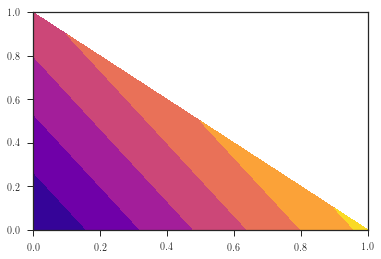

In [60]:
x = np.asarray([0, 1,1.2, 2, 3, 0.5, 1.5, 2.5, 1, 2, 1.5,2.0])
y = np.asarray([0, 0,0.2, 0, 0, 1.0, 1.0, 1.0, 2, 2, 3.0,3.5])
x=tern_data[:,0]
y=tern_data[:,1]

#triangles = [[0, 1, 4], [1, 2, 5], [2, 3, 6], [1, 5, 4], [2, 6, 5], [4, 5, 7],
             #[5, 6, 8], [5, 8, 7], [7, 8, 9]]
#triang = tri.Triangulation(x, y, triangles)
triang = tri.Triangulation(x,y)

# Interpolate to regularly-spaced quad grid.
z = np.cos(1.5 * x) * np.cos(1.5 * y)
#xi, yi = np.meshgrid(np.linspace(0, 3, 20), np.linspace(0, 3, 20))


z=tern_data[:,3] 

# Plot the triangulation.
plt.tricontourf(triang, z,cmap='plasma')
#plt.triplot(triang, 'ko-')


In [61]:
#You need to set up the coordinates to calculate this at.
tern_data = []
percent_both = np.linspace(0,1,100)
percent_one = np.linspace(0,1,100)

#Redfine the cost array to what you used initially
f1 = 0.     #How bad is it to completely miss someone's treatment? (equal emphasis as correct treatment is 1.0)
f2 = 2.    #How bad is it to waste an antimalarial or antibiotic? 
C = np.array([1.,-(f1+f2),1.-f2,-f1,-(f1+f2),1.,1.-f2,-f1,(1.-f1)/2.,(1.-f1)/2.,1.,-f1,-f2,-f2,-2.*f2,1.])

for pb in percent_both:
    for po in percent_one:
        if(pb+po)<=1.:
            pnone = 1.-(pb+po)
            KSCats = np.array([0,0,0.5*po,0,0,0,0.5*po,0.,0.,0.,pb,0.,0.,0.,pnone,0.]) #percent in each category 
                                                                                       #under KS policy 
            rpp = np.sum(KSCats*C)/(pb+po+pnone)
            tern_data.append([pb,po,pnone,rpp])
tern_data = np.array(tern_data)

figure(figsize=(12,8))
# barycentric coords: (a,b,c)
a=tern_data[:,0]
b=tern_data[:,1]
c=tern_data[:,3] 

<Figure size 864x576 with 0 Axes>